In [ ]:
# AMex timeseries 
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [3]:
# ========================
# 1. Load and Preprocess
# ========================
df = pd.read_parquet('/kaggle/input/amex-dataset/amex/train_data.parquet')
df['id4'] = pd.to_datetime(df['id4'])  # Ensure datetime
test_df = pd.read_parquet('/kaggle/input/amex-prv-r3/test_data_r3.parquet')
test_df['id4'] = pd.to_datetime(test_df['id4'])  # Ensure datetime

In [4]:
# Drop high-null columns
null_pct = df.isnull().mean()
cols_to_drop = null_pct[null_pct > 0.90].index.tolist()
ctd =   ['f365','f125']   #['f125', 'f127', 'f140', 'f141', 'f142', 'f143', 'f362', 'f365']
df.drop(columns=cols_to_drop+ctd, inplace=True)
df['y'] = pd.to_numeric(df['y'], errors='coerce').fillna(0).astype(int)

In [5]:
test_df.drop(columns=cols_to_drop, inplace=True)

In [6]:
# Step 2: Sort chronologically
df = df.sort_values(by=['id4', 'id2']).reset_index(drop=True)
test_df = test_df.sort_values(by=['id4', 'id2']).reset_index(drop=True)

In [7]:

cutoff_time = df['id4'].iloc[(int)(770164*0.90)]
train_df = df[df['id4'] < cutoff_time].copy()
val_df = df[df['id4'] >= cutoff_time].copy()

In [8]:
def generate_time_features(df, time_col='id4', user_col='id2', offer_col='id3', session_gap_seconds=1800, recent_window=3600):
    df = df.sort_values(by=[user_col, time_col]).copy()
    
    # 1. Time Since Last Event (User)
    df['user_prev_time'] = df.groupby(user_col)[time_col].shift(1)
    df['time_since_last_event'] = (df[time_col] - df['user_prev_time']).dt.total_seconds().fillna(-1)

    # 2. Time Since First Event (User/Offer)
    df['user_first_time'] = df.groupby(user_col)[time_col].transform('min')
    df['offer_first_time'] = df.groupby(offer_col)[time_col].transform('min')
    df['user_time_since_first_event'] = (df[time_col] - df['user_first_time']).dt.total_seconds()
    df['offer_time_since_first_event'] = (df[time_col] - df['offer_first_time']).dt.total_seconds()

    # 4. Assign Session IDs
    df['gap'] = (df[time_col] - df['user_prev_time']).dt.total_seconds()
    df['new_session'] = (df['gap'] > session_gap_seconds).fillna(True).astype(int)
    df['session_id'] = df.groupby(user_col)['new_session'].cumsum()
    
    # 5. Time Since Session Start
    df['session_start_time'] = df.groupby([user_col, 'session_id'])[time_col].transform('min')
    df['time_since_session_start'] = (df[time_col] - df['session_start_time']).dt.total_seconds()

    # 6. Recent User Activity Count in Past X Seconds
    # Note: Lightweight rolling window with limited lag
    df['recent_user_activity'] = (
        df.groupby(user_col)[time_col]
          .transform(lambda x: x.diff().dt.total_seconds().rolling(10, min_periods=1)
                     .apply(lambda s: (s <= recent_window).sum(), raw=True)).fillna(0)
    )

    # # 7. Time Context Features
    df['hour'] = df[time_col].dt.hour
    # df['dow'] = df[time_col].dt.dayofweek
    # df['is_weekend'] = df['dow'].isin([5, 6]).astype(int)
    
    df['seen_offer_before'] = df.duplicated(subset=['id2', 'id3']).astype(int)
    df['last_seen_offer_time'] = df.groupby(['id2', 'id3'])['id4'].shift(1)
    df['time_since_last_offer'] = (df['id4'] - df['last_seen_offer_time']).dt.total_seconds().fillna(-1)
    df['user_next_time'] = df.groupby('id2')['id4'].shift(-1)
    df['time_until_next_event'] = (df['user_next_time'] - df['id4']).dt.total_seconds().fillna(-1)


    # Drop temp columns
    df.drop(columns=['gap', 'new_session', 'session_start_time', 'user_prev_time','last_seen_offer_time','user_next_time'], inplace=True)

    return df


In [9]:
train_df['source'] = 'train'
val_df['source'] = 'val'
test_df['source']='test'
df_all = pd.concat([train_df, val_df,test_df], axis=0)
# Generate time-based features
df_all = generate_time_features(df_all)
# Split back
train_df = df_all[df_all['source'] == 'train'].drop(columns=['source'])
val_df   = df_all[df_all['source'] == 'val'].drop(columns=['source'])
test_df = df_all[df_all['source'] == 'test'].drop(columns=['source'])

In [10]:

if 'id3' in train_df.columns:
    train_df['offer_total_interactions'] = train_df.groupby('id3').cumcount()
    train_df['offer_total_positives'] = train_df.groupby('id3')['y'].cumsum() - train_df['y']
    train_df['offer_ctr'] = train_df['offer_total_positives'] / train_df['offer_total_interactions'].replace(0, 1)

In [11]:

if 'id3' in train_df.columns:
    offer_agg = train_df.groupby('id3')['y'].agg(
        offer_total_interactions=('count'),
        offer_total_positives=('sum')
    ).assign(
        offer_ctr=lambda df: df['offer_total_positives'] / df['offer_total_interactions'].replace(0, 1)
    )
    val_df = val_df.merge(offer_agg, on='id3', how='left').fillna(0)
def drop_unwanted_ids(df):
    return df.drop(columns=[col for col in df.columns if col.startswith('id') and col != 'id3' ], errors='ignore')
X_train = drop_unwanted_ids(train_df.drop(columns=['y', 'id4' ], errors='ignore'))
X_val = drop_unwanted_ids(val_df.drop(columns=['y', 'id4'], errors='ignore'))
y_train = train_df['y'].values
y_val = val_df['y'].values

/tmp/ipykernel_36/706844505.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_df = val_df.merge(offer_agg, on='id3', how='left').fillna(0)


In [12]:
X_train = X_train.drop(columns=['offer_first_time', 'user_first_time'], errors='ignore')
X_val   = X_val.drop(columns=['offer_first_time', 'user_first_time'], errors='ignore')

In [13]:
encoders = {}
UNSEEN_CODE = {}
for col in tqdm(X_train.select_dtypes(include='object').columns):
    try:
        # Attempt a numeric conversion
        X_train[col] = pd.to_numeric(X_train[col])
        X_val[col]   = pd.to_numeric(X_val[col])
        continue      # if that worked, skip the categorical logic
    except:
        # Only columns that fail numeric conversion enter here:

        # 1) Cast to string & fill na
        X_train[col] = X_train[col].astype(str).fillna("NA")
        X_val[col]   = X_val[col].astype(str).fillna("NA")

        # 2) Fit encoder on train+val
        le = LabelEncoder()
        le.fit(list(X_train[col].unique()) + list(X_val[col].unique()))

        # 3) Store encoder + reserve unseen code
        encoders[col]    = le
        UNSEEN_CODE[col] = le.classes_.shape[0]

        # 4) Transform both splits
        X_train[col] = le.transform(X_train[col])
        X_val[col]   = le.transform(X_val[col])


100%|██████████| 329/329 [00:57<00:00,  5.73it/s]


In [14]:
# Align both train and val to have the exact same columns
common_cols = list(set(X_train.columns) & set(X_val.columns))
X_train = X_train[common_cols].copy()
X_val = X_val[common_cols].copy()
# OPTIONAL (for reproducibility & safety): sort columns identically
X_train = X_train.sort_index(axis=1)
X_val = X_val.sort_index(axis=1)

In [15]:
X_train.fillna(-999, inplace=True)
X_val.fillna(-999, inplace=True)

In [16]:
from xgboost import XGBRanker

# --- Group definitions for ranking ---
group_train = train_df.groupby('id2').size().tolist()
group_val = val_df.groupby('id2').size().tolist()

# --- Model setup with your LB-tuned hyperparameters ---
ranker1 = XGBRanker(
    objective='rank:pairwise',           # MAP/Ranking objective
    eval_metric='map@7',                 # Directly optimize leaderboard metric

    # GPU & performance
    tree_method='gpu_hist',
    max_bin=1024,
    nthread=4,
    random_state=42,

    # Learning & complexity
    learning_rate=0.04420096546653645,
    max_depth=12,
    min_child_weight=46,
    subsample=0.811764997184529,
    colsample_bytree=0.6940853675702088,

    # Regularization
    reg_lambda=5.1983874679927515,
    reg_alpha=4.307761284697946,

    # Booster
    n_estimators=5000,
    verbosity=1
)

In [17]:
# --- Fit model ---
ranker1.fit(
    X_train, y_train,
    group=group_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_group=[group_train, group_val],
    early_stopping_rounds=200,
    verbose=50   # Prints train + val scores every 100 rounds
)

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [05:30:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-map@7:0.95018	validation_1-map@7:0.94789
[50]	validation_0-map@7:0.98640	validation_1-map@7:0.97539
[100]	validation_0-map@7:0.98882	validation_1-map@7:0.97622
[150]	validation_0-map@7:0.99045	validation_1-map@7:0.97684
[200]	validation_0-map@7:0.99187	validation_1-map@7:0.97736
[250]	validation_0-map@7:0.99305	validation_1-map@7:0.97746
[300]	validation_0-map@7:0.99423	validation_1-map@7:0.97769
[350]	validation_0-map@7:0.99521	validation_1-map@7:0.97756
[400]	validation_0-map@7:0.99608	validation_1-map@7:0.97776
[450]	validation_0-map@7:0.99665	validation_1-map@7:0.97790
[500]	validation_0-map@7:0.99711	validation_1-map@7:0.97792
[550]	validation_0-map@7:0.99759	validation_1-map@7:0.97792
[600]	validation_0-map@7:0.99795	validation_1-map@7:0.97781
[628]	validation_0-map@7:0.99812	validation_1-map@7:0.97801


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=0.6940853675702088,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric='map@7', feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          learning_rate=0.04420096546653645, max_bin=1024,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=12, max_leaves=None, min_child_weight=46, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=5000,
          n_jobs=None, nthread=4, num_parallel_tree=None, ...)

In [18]:
map_df = pd.DataFrame({
    'user_id': val_df['id2'].reset_index(drop=True),
    'item_id': val_df['id3'].reset_index(drop=True),
    'y_true': y_val,
    'y_pred': ranker1.predict(X_val, iteration_range=(0,ranker1.best_iteration+1))
})
# map_tr_df = pd.DataFrame({
#     'user_id': train_df['id2'].reset_index(drop=True),
#     'item_id': train_df['id3'].reset_index(drop=True),
#     'y_true': y_train,
#     'y_pred': ranker1.predict(X_train, iteration_range=(0,ranker1.best_iteration+1))
# })

def apk(actual, predicted, k=7):
    if not actual:
        return 0.0
    predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), k)

def mapk(df, k=7):
    average_precisions = []
    for user_id, user_df in df.groupby('user_id'):
        user_df_sorted = user_df.sort_values('y_pred', ascending=False)
        predicted = user_df_sorted['item_id'].tolist()
        actual = user_df_sorted[user_df_sorted['y_true'] == 1]['item_id'].tolist()
        if actual:
            ap = apk(actual, predicted, k)
            average_precisions.append(ap)
    return np.mean(average_precisions) if average_precisions else 0.0

# 4. Compute MAP@7
map7_score = mapk(map_df, k=7)
print(f"Validation MAP@7: {map7_score:.5f}")
# print(f"Train MAP@7: {mapk(map_tr_df, k=7):.5f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [05:32:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [05:32:23] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Validation MAP@7: 0.80255


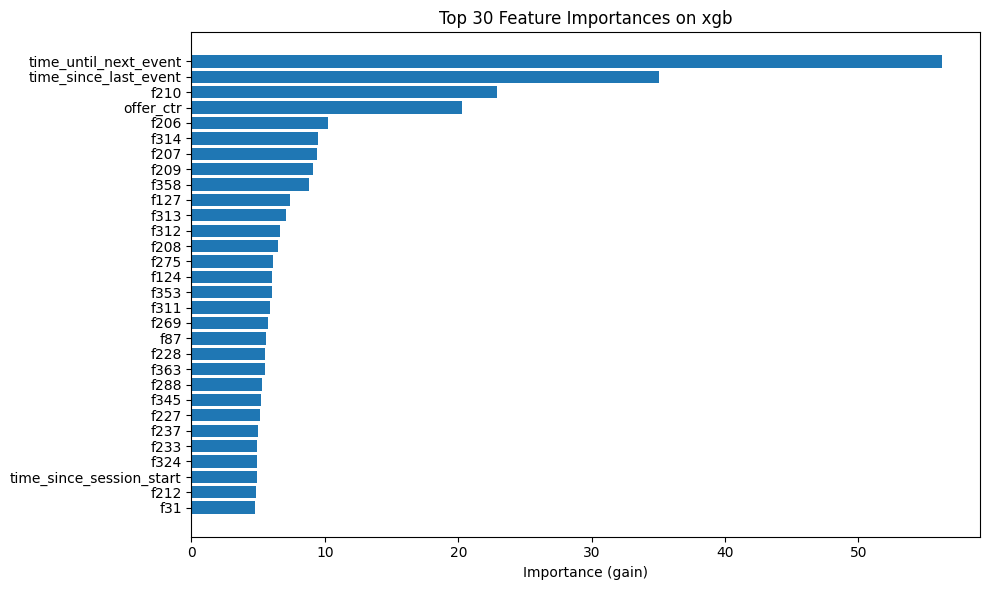

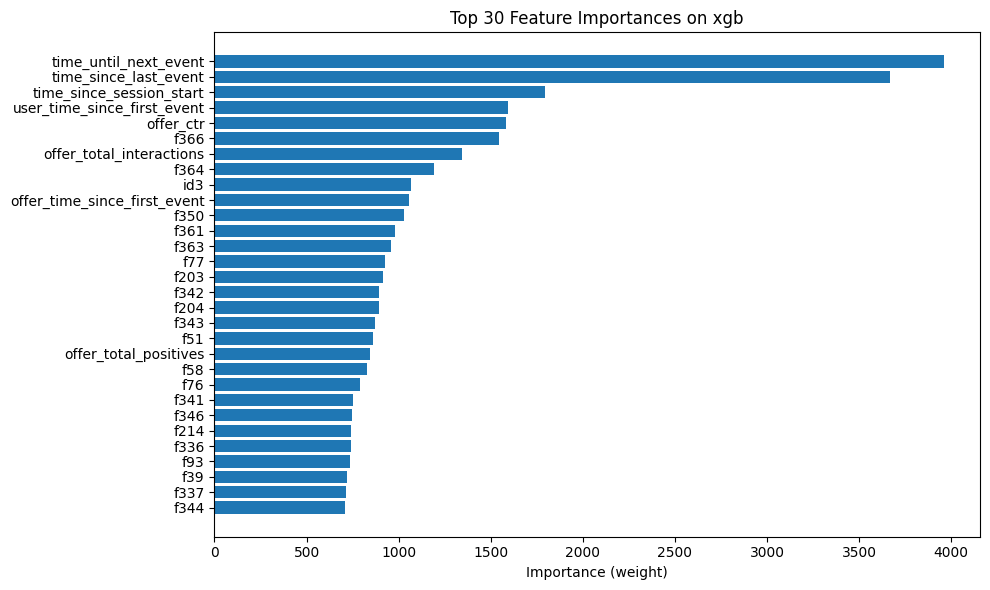

In [19]:
import xgboost as xgb
import matplotlib.pyplot as plt

def plot_xgb_feature_importance(model, top_k=20, importance_type='gain'):
    """
    Plots the top_k most important features based on the specified importance type.
    
    Args:
        model: Trained XGBoost model (Booster object).
        top_k: Number of top features to display.
        importance_type: One of 'weight', 'gain', 'cover', 'total_gain', 'total_cover'.
    """
    # Get feature importances
    # importance_type = 'gain'  # or 'weight', 'cover', 'total_gain', 'total_cover'
    importance = model.get_booster().get_score(importance_type=importance_type)

    # Convert to DataFrame
    importance_df = pd.DataFrame({
        'feature': list(importance.keys()),
        'importance': list(importance.values())
    }).sort_values(by='importance', ascending=False).head(top_k)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'][::-1], importance_df['importance'][::-1])
    plt.xlabel(f'Importance ({importance_type})')
    plt.title(f'Top {top_k} Feature Importances on xgb')
    plt.tight_layout()
    plt.show()

# Usage example

plot_xgb_feature_importance(ranker1, top_k=30, importance_type='gain')  # model is your trained xgb.Booster
# Plot F-score (frequency-based) importance
plot_xgb_feature_importance(ranker1, top_k=30, importance_type='weight')


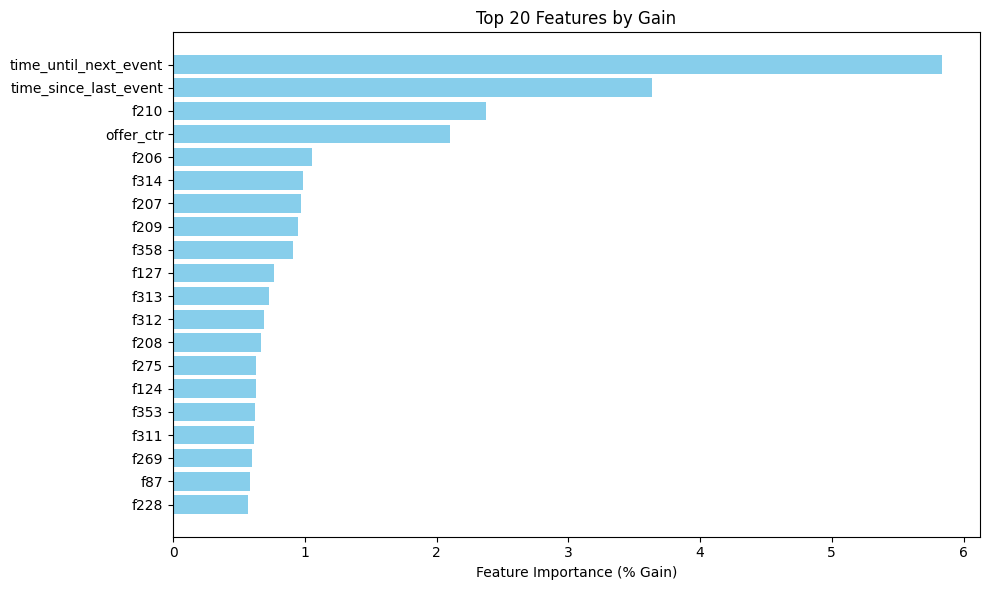

In [20]:
import pandas as pd
# Step 1: Extract gain-based importance
importance_dict = ranker1.get_booster().get_score(importance_type='gain')
# Step 2: Convert to DataFrame
feat_imp_df = pd.DataFrame(list(importance_dict.items()), columns=['feature', 'gain'])
# Step 3: Normalize to percentage
feat_imp_df['gain_pct'] = 100 * feat_imp_df['gain'] / feat_imp_df['gain'].sum()
feat_imp_df = feat_imp_df.sort_values(by='gain_pct', ascending=False)
# Step 4: Save to XLSX
feat_imp_df.to_excel("feature_importance_by_gain.xlsx", index=False)

import pandas as pd
import matplotlib.pyplot as plt
# Get feature importance dictionary from booster
importance_dict = ranker1.get_booster().get_score(importance_type='gain')
# Convert to DataFrame
feat_imp_df = pd.DataFrame(list(importance_dict.items()), columns=['feature', 'gain'])
# Normalize to percentage
feat_imp_df['gain_pct'] = 100 * feat_imp_df['gain'] / feat_imp_df['gain'].sum()
# Sort descending
feat_imp_df = feat_imp_df.sort_values(by='gain_pct', ascending=False)
plt.figure(figsize=(10, 6))
top_n = 20  # adjust to view more/less
plt.barh(feat_imp_df['feature'][:top_n][::-1], feat_imp_df['gain_pct'][:top_n][::-1], color='skyblue')
plt.xlabel("Feature Importance (% Gain)")
plt.title(f"Top {top_n} Features by Gain")
plt.tight_layout()
plt.show()

In [ ]:
#  Compute within-test history features (no labels)
if 'id3' in train_df.columns:
    offer_agg = df.groupby('id3')['y'].agg(
        offer_total_interactions=('count'),
        offer_total_positives=('sum')
    ).assign(
        offer_ctr=lambda df: df['offer_total_positives'] / df['offer_total_interactions'].replace(0, 1)
    )
    test_df = test_df.merge(offer_agg, on='id3', how='left').fillna(0)

# 4) Drop IDs, encode, align, predict
def drop_unwanted_ids(df):
    return df.drop(columns=[c for c in df.columns if c.startswith('id') and c!='id3'],
                   errors='ignore')

X_test = drop_unwanted_ids(
    test_df.drop(columns=['id4','user_prev_time'],errors='ignore')
)

In [22]:
#  Ensure same column order
X_test = X_test[X_train.columns].copy()
X_test = X_test.sort_index(axis=1)

for col in tqdm(X_test.select_dtypes(include='object').columns):
    try:
        # 1) Try numeric conversion
        X_test[col] = pd.to_numeric(X_test[col])
        continue
    except:
        # 2) Only non‑numeric columns reach here:
        X_test[col] = X_test[col].astype(str).fillna("NA")

        if col in encoders:
            # 3a) Re‑use your saved encoder
            le          = encoders[col]
            unseen_code = UNSEEN_CODE[col]
            X_test[col] = X_test[col].map(
                lambda v: int(le.transform([v])[0]) if v in le.classes_ else unseen_code
            )
        else:
            # 3b) Brand‑new column
            le = LabelEncoder().fit(X_test[col])
            X_test[col] = le.transform(X_test[col])
            encoders[col]    = le
            UNSEEN_CODE[col] = le.classes_.shape[0]

100%|██████████| 329/329 [02:17<00:00,  2.39it/s]


In [23]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [24]:
test_preds1 = ranker1.predict(X_test,iteration_range=(0, ranker1.best_iteration + 1))
test_df['y_pred']=sigmoid(test_preds1)

In [25]:
import numpy as np
sub = pd.read_csv('/kaggle/input/sub-temp-r3/submission_template_r3.csv')
# Add y_pred to test_df
test_df = test_df.copy()
# test_df['pred'] = y_pred

# Ensure test_df has column named 'id1'
if test_df.columns[0] != 'id1':
    test_df.rename(columns={test_df.columns[0]: 'id1'}, inplace=True)

# Build a mapping: id1 → pred
id_to_pred = dict(zip(test_df['id1'], test_df['y_pred']))

# Fill predictions in submission
sub['pred'] = sub['id1'].map(id_to_pred)

# Check if any were not matched
missing = sub['pred'].isna().sum()
print(f"✅ Filled predictions. 🔍 Missing matches: {missing}")

✅ Filled predictions. 🔍 Missing matches: 0


In [28]:
sub.to_csv('r3_submission_file<RPM>.csv',index=False)

In [26]:
sub

,id1,id2,id3,id5,pred
0,1312431_97715251_16-23_2023-11-06 15:46:57.950,1312431,97715251,2023-11-06,0.005730
1,1312431_69026_16-23_2023-11-06 15:47:52.848,1312431,69026,2023-11-06,0.051800
2,1312431_521695_16-23_2023-11-06 15:47:52.817,1312431,521695,2023-11-06,0.002635
3,1312431_43258448_16-23_2023-11-06 15:46:57.905,1312431,43258448,2023-11-06,0.042974
4,1312431_633765_16-23_2023-11-06 15:47:52.765,1312431,633765,2023-11-06,0.095354
...,...,...,...,...,...
337709,1362907_94064959_16-23_2023-11-04 18:57:12.105,1362907,94064959,2023-11-04,0.011915
337710,1362907_960643_16-23_2023-11-04 18:54:25.763,1362907,960643,2023-11-04,0.019712
337711,1362907_433824_16-23_2023-11-04 18:51:31.349,1362907,433824,2023-11-04,0.214908
337712,1362907_99856_16-23_2023-11-04 18:54:26.768,1362907,99856,2023-11-04,0.003294
